<a href="https://colab.research.google.com/github/faizuddin/ISB46703/blob/main/sentiment_analysis_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Principles of AI (ISB46703)
## Communication and Perception: Deep Learning for Natural Language Processing
In this tutorial, we will look into how to implement a Sentiment Analysis (quite often referred simply as NLP) pipeline that combines a traditional supervised learning algorithm with a deep learning algorithm to interpret and classify emotions in text information.

Hence, the main objective is going to be to demonstrate how to set up that pipeline that facilitates collection, preprocessing and classifying labeled text data to finally training and evaluating deep learning models in [Keras](https://keras.io). 

We also will look into overfit model, a case where the model memorises the noise and fits too closely to the training set, the model becomes *overfitted* and it is unable to generalise well to new data. If a model cannot generalise well to new data, then it will not be able to perform the classification or prediction tasks that it was intended for.

### NLP Motivation
Imagine the task of determining whether a product’s review is positive or negative; you could do it yourself just by reading it, right? But what happens when the company you work for sells 2000 products every single day? Would you read all the reviews and manually classify them? There’s where Sentiment Analysis comes in and makes your life and job easier.




## Setup
We start by importing the necessary packages and configuring some parameters. We will use Keras to fit the deep learning models. The training data is the [Twitter US Airline Sentiment data set from Kaggle](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment).

In [1]:
!pip install nltk

In [11]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
import nltk

# Packages for data preparation
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

In [4]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent
MAX_LEN = 20  # Maximum number of words in a sequence

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

##Enabling and testing the GPU

You'll need to enable GPUs for the notebook to accelerate computation:
Navigate to Edit→Notebook Settings
Select GPU from the Hardware Accelerator drop-down.

Next, confirm that we can connect to the GPU with tensorflow:

In [6]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Helper functions
We will use some helper functions throughout (to ensure our code is neat and readable!)

In [12]:
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history


def eval_metric(model, history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_name)
    plt.title('Comparing training and validation ' + metric_name + ' for ' + model.name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    print()
    print('Test accuracy: {0:.2f}%'.format(results[1]*100))
    return results

    
def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)


def compare_models_by_metric(model_1, model_2, model_hist_1, model_hist_2, metric):
    '''
    Function to compare a metric between two models 
    
    Parameters:
        model_hist_1 : training history of model 1
        model_hist_2 : training history of model 2
        metrix : metric to compare, loss, acc, val_loss or val_acc
        
    Output:
        plot of metrics of both models
    '''
    metric_model_1 = model_hist_1.history[metric]
    metric_model_2 = model_hist_2.history[metric]

    e = range(1, NB_START_EPOCHS + 1)
    
    metrics_dict = {
        'acc' : 'Training Accuracy',
        'loss' : 'Training Loss',
        'val_acc' : 'Validation accuracy',
        'val_loss' : 'Validation loss'
    }
    
    metric_label = metrics_dict[metric]

    plt.plot(e, metric_model_1, 'bo', label=model_1.name)
    plt.plot(e, metric_model_2, 'b', label=model_2.name)
    plt.xlabel('Epoch number')
    plt.ylabel(metric_label)
    plt.title('Comparing ' + metric_label + ' between models')
    plt.legend()
    plt.show()
    
def optimal_epoch(model_hist):
    '''
    Function to return the epoch number where the validation loss is
    at its minimum
    
    Parameters:
        model_hist : training history of model

    Output:
        epoch number with minimum validation loss
    '''
    min_epoch = np.argmin(model_hist.history['val_loss']) + 1
    print("Minimum validation loss reached in epoch {}".format(min_epoch))
    return min_epoch

##Data preparation

###Data cleaning

We load the csv with the tweets and perform a random shuffle. It's a good practice to shuffle the data before splitting between a train and test set. That way the sentiment classes are equally distributed over the train and test sets. We'll only keep the ***text*** column as input and the `airline_sentiment` column as the target.

The next thing we'll do is ***removing stopwords***. Stopwords do not have any value for predicting the sentiment. Furthermore, as we want to build a model that can be used for other airline companies as well, we remove the ***mentions***. (i.e. @abcde)

In [13]:
df = pd.read_csv('Tweets.csv')
df = df.reindex(np.random.permutation(df.index))  
df = df[['text', 'airline_sentiment']]
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)

##Train-Test split

The evaluation of the model performance needs to be done on a separate test set. As such, we can estimate how well the model generalises (this is important!). This is done with the `train_test_split` method of scikit-learn.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 13176
# Test data samples: 1464


##Converting words to numbers

To use the text as input for a model, we first need to convert the words into tokens, which simply means converting the words to integers that refer to an index in a dictionary. Here we will only keep the most frequent words in the training set.

We clean up the text by applying ***filters*** and putting the words to ***lowercase***. Words are separated by spaces.

In [15]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               char_level=False,
               split=' ')
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 13176 documents
10000 words in dictionary
Top 5 most common words are: [('flight', 3524), ('not', 1434), ('no', 1338), ('get', 1219), ('t', 1102)]


After having created the dictionary we can convert the text of a tweet to a vector with `NB_WORDS` values. With `mode=binary`, it contains an indicator whether the word appeared in the tweet or not. This is done with the `texts_to_matrix `method of the `Tokenizer`.

In [16]:
X_train_oh = tk.texts_to_matrix(X_train, mode='binary')
X_test_oh = tk.texts_to_matrix(X_test, mode='binary')

##Converting the target classes to numbers

We need to convert the target classes to numbers as well, which in turn are one-hot-encoded with the `to_categorical` method in Keras

In [17]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"neutral" is converted into 0
"0" is converted into [1. 0. 0.]


##Splitting off a validation set

Now that our data is ready, we split off a validation set. This validation set will be used to evaluate the model performance when we tune the parameters of the model.

In [18]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (1318, 10000)


##Deep learning

###Creating a model that overfits

We start with a model that overfits. It has 2 densely connected layers of 64 elements. The `input_shape` for the first layer is equal to the number of words we kept in the dictionary and for which we created one-hot-encoded features.

As we need to **predict 3 different sentiment classes**, the last layer has 3 elements. The ***softmax*** activation function makes sure the three probabilities sum up to 1.

The number of parameters to train is computed as **(nb inputs x nb elements in hidden layer) + nb bias terms**. The number of inputs for the first layer equals the number of words in our corpus. The subsequent layers have the number of outputs of the previous layer as inputs. So the number of parameters per layer are:

1. First layer : (10000 x 64) + 64 = 640064
2. Second layer : (64 x 64) + 64 = 4160
3. Last layer : (64 x 3) + 3 = 195

In [19]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(3, activation='softmax'))
base_model._name = "baselineModel"
base_model.summary()

Model: "baselineModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


Because this project is a **multi-class**, **single-label prediction**, we use `categorical_crossentropy` as the loss function and softmax as the final activation function. We fit the model on the train data and validate on the validation set. We run for a ***predetermined number of epochs*** and will see when the model starts to overfit.

In [20]:
base_history = deep_model(base_model, X_train_rest, y_train_rest, X_valid, y_valid)
base_min = optimal_epoch(base_history)

Minimum validation loss reached in epoch 3


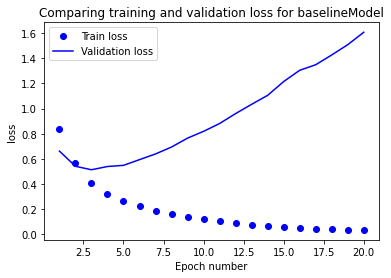

In [21]:
eval_metric(base_model, base_history, 'loss')

In the beginning the validation loss goes down. But at epoch 3 this stops and the validation loss starts increasing rapidly. This is when the models begins to **overfit**.

The training loss continues to go down and almost reaches zero at epoch 20. This is normal as the model is trained to fit the train data as good as possible.

##Handling overfitting

Now, we can try to do something about the overfitting. There are different options to do that.

1. Option 1: **reduce the network's capacity** by removing layers or reducing the number of elements in the hidden layers
2. Option 2: **apply regularization**, which comes down to adding a cost to the loss function for large weights
3. Option 3: **use Dropout layers**, which will randomly remove certain features by setting them to zero

###Reducing the network's capacity

Our first model has a large number of trainable parameters. The higher this number, the easier the model can memorize the target class for each training sample. Obviously, this is not ideal for generalising on new data.

By lowering the capacity of the network, you force it to learn the patterns that matter, or that minimize the loss. On the other hand, reducing the network's capacity too much, will lead to **underfitting**. The model will not be able to learn the relevant patterns in the train data.

We reduce the network's capacity by removing one hidden layer and lowering the number of elements in the remaining layer to 16.

In [22]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(16, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(3, activation='softmax'))
reduced_model._name = 'reducedModel'
reduced_model.summary()

Model: "reducedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                160016    
                                                                 
 dense_4 (Dense)             (None, 3)                 51        
                                                                 
Total params: 160,067
Trainable params: 160,067
Non-trainable params: 0
_________________________________________________________________


In [23]:
reduced_history = deep_model(reduced_model, X_train_rest, y_train_rest, X_valid, y_valid)
reduced_min = optimal_epoch(reduced_history)

Minimum validation loss reached in epoch 12


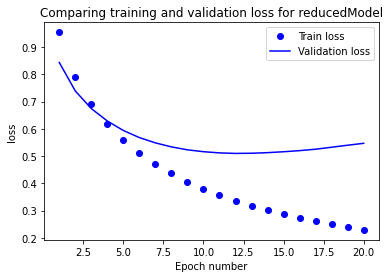

In [24]:
eval_metric(reduced_model, reduced_history, 'loss')

We can see that it takes more epochs before the reduced model starts overfitting. The validation loss also goes up slower than our first model.

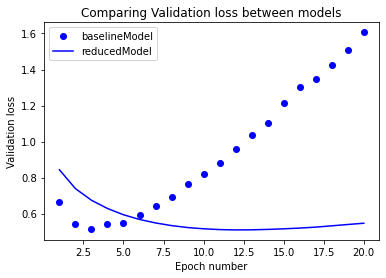

In [25]:
compare_models_by_metric(base_model, reduced_model, base_history, reduced_history, 'val_loss')

When we compare the validation loss of the baseline model, it is clear that the reduced model starts overfitting at a later epoch. The validation loss stays lower much longer than the baseline model.

###Applying regularization

To address overfitting, we can apply weight regularization to the model. This will add a cost to the loss function of the network for large weights (or parameter values). As a result, you get a simpler model that will be forced to learn only the relevant patterns in the train data.

There are **L1** regularization and **L2** regularization.

1. L1 regularization will add a cost with regards to the **absolute value of the parameters**. It will result in some of the weights to be equal to zero.
2. L2 regularization will add a cost with regards to the **squared value of the parameters**. This results in smaller weights.

Let's try with L2 regularization.

In [26]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(3, activation='softmax'))
reg_model._name = 'L1L2regModel'
reg_model.summary()

Model: "L1L2regModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                640064    
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [27]:
reg_history = deep_model(reg_model, X_train_rest, y_train_rest, X_valid, y_valid)
reg_min = optimal_epoch(reg_history)

Minimum validation loss reached in epoch 5


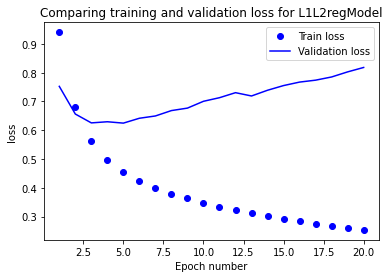

In [28]:
eval_metric(reg_model, reg_history, 'loss')

For the regularized model we notice that it starts overfitting in the same epoch as the baseline model. However, the loss increases much slower afterwards.

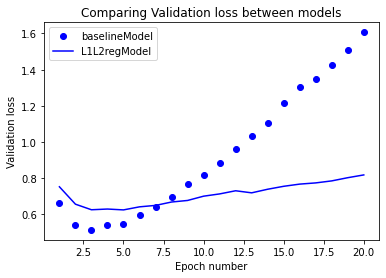

In [29]:
compare_models_by_metric(base_model, reg_model, base_history, reg_history, 'val_loss')

###Adding dropout layers

The last option we'll try is to add Dropout layers. A Dropout layer will randomly set output features of a layer to zero.

In [30]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(3, activation='softmax'))
drop_model._name = 'dropoutModel'
drop_model.summary()

Model: "dropoutModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 3)                 195       
                                                                 
Total params: 644,419
Trainable params: 644,419
Non-trainable params: 0
_________________________________________________________________


In [31]:
drop_history = deep_model(drop_model, X_train_rest, y_train_rest, X_valid, y_valid)
drop_min = optimal_epoch(drop_history)

Minimum validation loss reached in epoch 5


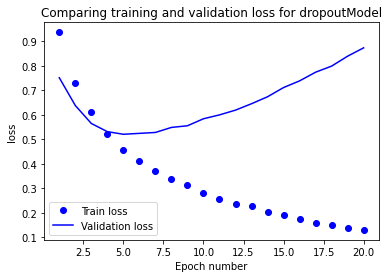

In [32]:
eval_metric(drop_model, drop_history, 'loss')

The model with dropout layers starts overfitting later than the baseline model. The loss also increases slower than the baseline model.

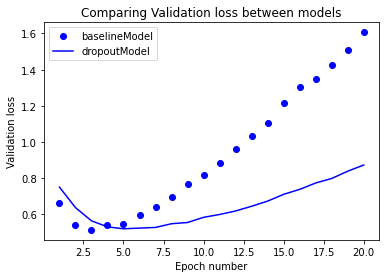

In [33]:
compare_models_by_metric(base_model, drop_model, base_history, drop_history, 'val_loss')

The model with the Dropout layers starts overfitting later. Compared to the baseline model the loss also remains much lower.

##Training on the full train data and evaluation on test data
At first sight the reduced model seems to be the best model for generalisation. But let's check that on the test set.

In [34]:
base_results = test_model(base_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, base_min)

46/46 [==============================] - 0s 4ms/step - loss: 1.1379 - accuracy: 0.7466

Test accuracy: 74.66%


In [35]:
reduced_results = test_model(reduced_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reduced_min)

46/46 [==============================] - 0s 4ms/step - loss: 0.6327 - accuracy: 0.7842

Test accuracy: 78.42%


In [36]:
reg_results = test_model(reg_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, reg_min)

46/46 [==============================] - 0s 4ms/step - loss: 0.7978 - accuracy: 0.7746

Test accuracy: 77.46%


In [37]:
drop_results = test_model(drop_model, X_train_oh, y_train_oh, X_test_oh, y_test_oh, drop_min)

46/46 [==============================] - 0s 4ms/step - loss: 0.8672 - accuracy: 0.7801

Test accuracy: 78.01%


##Conclusion

We can identify overfitting by looking at validation metrics like loss or accuracy. Usually, the validation metric stops improving after a certain number of epochs and begins to decrease afterward. The training metric continues to improve because the model seeks to find the best fit for the training data.

There are several manners in which we can reduce overfitting in deep learning models. The best option is to get more training data. Unfortunately, in real-world situations, you often do not have this possibility due to time, budget, or technical constraints.

As shown above, all three options help to reduce overfitting. We manage to increase the accuracy on the test data substantially. Among these three options, the model with the **Reduced** model performs the best on the test data.